In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from physynthtrainer.utils import paint_arr_to_jpg
from ultralytics import YOLO
from astropy.io import fits# log scale
from matplotlib.colors import LogNorm
from skimage.transform import resize

%load_ext autoreload
%autoreload 2


In [2]:
model_path = '/data07/peijinz/ML/type3MLgen/runs/detect/yolo11l_train_withbg/weights/best.pt'

In [3]:

model = YOLO(model_path)

In [4]:
data_fits = "/nas7a/beam/fits_v1/fits/2025/ovro-lwa.lev1_bmf_256ms_96kHz.2025-09-29.dspec_I.fits"

In [5]:
data = fits.getdata(data_fits)

hdu = fits.open(data_fits)
freqw_arr =np.array(hdu[1].data["sfreq"])

print(data.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/nas7a/beam/fits_v1/fits/2025/ovro-lwa.lev1_bmf_256ms_96kHz.2025-09-29.dspec_I.fits'

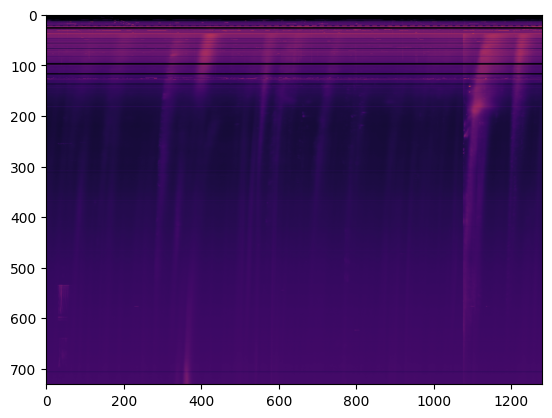

In [6]:


starting_idx = 55000
duration = 640*2

plt.imshow(data[0,0,:,starting_idx:starting_idx+duration], 
norm=LogNorm(vmax=300, vmin=0.4) ,cmap='inferno', aspect='auto')



In [7]:
out_size = (640,640)
data_out = resize(data[0,0,:,starting_idx:starting_idx+duration], out_size, anti_aliasing=True)

paint_arr_to_jpg(data_out.T, vmax=100, vmin=0.5, scaling='log')

In [8]:
results = model.predict(
    source="test.jpg",  # can be folder, image, or video
    save=True,         # save annotated images/videos
    save_txt=True,     # save YOLO-format .txt files
    save_conf=True,    # include confidence in .txt
    conf=0.8          # confidence threshold
)


image 1/1 /home/peijin/PhySynthTrainer/example/test.jpg: 640x640 8 t3s, 5 t3bs, 108.2ms
Speed: 2.0ms preprocess, 108.2ms inference, 104.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/peijin/PhySynthTrainer/example/runs/detect/predict3
1 label saved to /home/peijin/PhySynthTrainer/example/runs/detect/predict3/labels


In [11]:
npzpath = "../scripts/background_2024.npz"
data = np.load(npzpath)

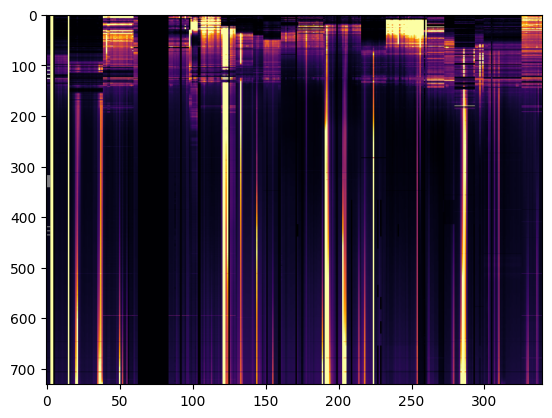

In [12]:
plt.imshow(data['background'].T, vmax=10, vmin=0.5, cmap='inferno', aspect='auto')



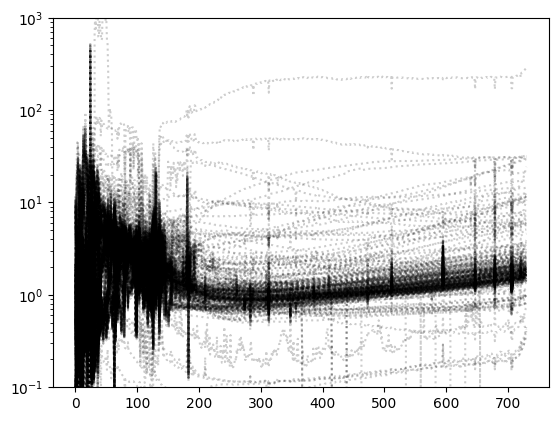

In [13]:
plt.plot(data['background'].T,':', color='k', alpha=0.2)

plt.ylim(0.1, 1000)
plt.yscale('log')




In [14]:
data['background'].shape

(340, 731)

In [15]:
bckgrd_list = []
for ndate in range(data['background'].shape[0]):
    thisday = data['background'][ndate,:]
    good_data = True    
    if np.max(thisday[200:]) > 5:
        good_data = False

    if np.min(thisday[200:]) < 0.5:
        good_data = False

    if good_data:
        bckgrd_list.append(thisday)

bckgrd_list = np.array(bckgrd_list)

In [16]:
bckgrd_list.shape

(259, 731)

[Text(0.5, 0, 'Frequency (MHz)'), Text(0, 0.5, 'Flux density (s.f.u.)')]

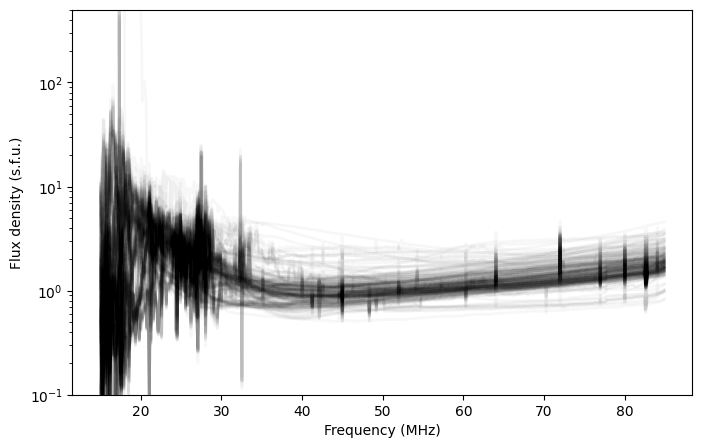

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(freqw_arr*1000, bckgrd_list.T, '-', color='k', alpha=0.03, linewidth=2)
ax.set_ylim(0.1, 500)
ax.set_yscale('log')


plt.setp(plt.gca(), xlabel='Frequency (MHz)', ylabel='Flux density (s.f.u.)')

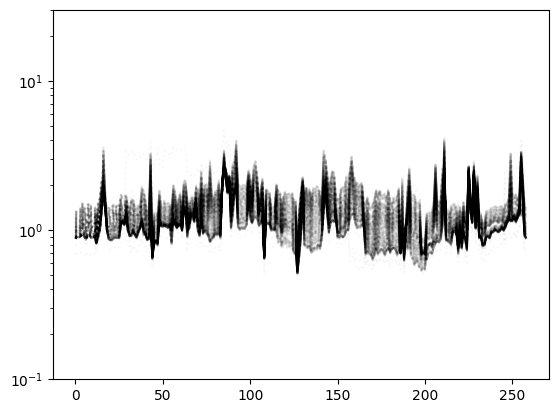

In [30]:
plt.plot(bckgrd_list[:,250:700],':', color='k', alpha=0.03)
plt.ylim(0.1, 30)
plt.yscale('log')

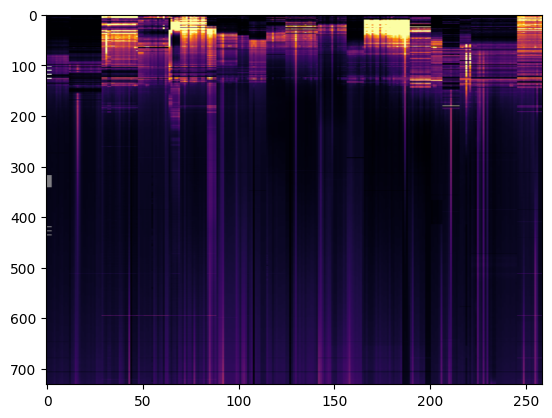

In [138]:
plt.imshow(bckgrd_list.T, vmax=10, vmin=0.5, cmap='inferno', aspect='auto')

In [139]:
# write bckgrd_list to npz
np.savez('bckgrd_list.npz', bckgrd_list=bckgrd_list)